In [1]:
import sys
import re
import json
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

from string import punctuation

In [2]:
prefix = 'yelp_dataset/'
file_stopword = prefix + 'stopword.list'

file_train = prefix + 'reviews_train.json'

file_dev = prefix + 'reviews_dev.json'
file_dev_label = prefix + 'reviews_dev_labels.txt'

file_test = prefix + 'reviews_test.json'
file_test_label = prefix + 'reviews_test_labels.txt'

In [3]:
def load_stopwords(infile: str) -> set:
    with open(infile) as f:
        stopwords = set(map(lambda x:x.strip(), f.readlines()))
    print(f'{len(stopwords)} stopwords loaded')
    return stopwords

stopwords = load_stopwords(file_stopword)

341 stopwords loaded


# Data Pre-processing and Exploratory Data Analysis (EDA)

In [4]:
def parse_text(text: str) -> List[str]:
    text = re.sub(r'[^a-zA-Z ]', '', text)
    tokens = [x.strip().lower() for x in text.split(' ') if x and x.lower() not in stopwords]
    return tokens

In [5]:
def preprocess(data_file: str, label_file: str = None) -> Tuple[List[List[str]], List[int]]:
    review_list, star_list = [], []

    reviews = {}
    stars = {}
    with open(data_file, 'r') as f:
        for json_str in f:
            obj = json.loads(json_str)
            review_id = obj["review_id"]
            review = obj['text'].strip()
            tokens = parse_text(review)
            reviews[review_id] = tokens

            if label_file is None:
                label = int(obj['stars'])
                review_list.append(tokens)
                star_list.append(label)

    if label_file:
        with open(label_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            review_id, star = line.strip().split()
            stars[review_id] = int(star)

        for review_id, tokens in reviews.items():
            review_list.append(tokens)
            star_list.append(stars[review_id])

    return review_list, star_list

In [6]:
review_list, star_list = preprocess(file_train)
assert len(review_list) == len(star_list)

print(f'Number of training samples: {len(review_list)}')

Number of training samples: 1255353


In [7]:
def get_top_token_counts(review_list: List[List[str]]) -> List[Tuple[str, int]]:
    token_cnt_dict = {}
    for tokens in review_list:
        for token in tokens:
            token_cnt_dict[token] = token_cnt_dict.get(token, 0) + 1

    sort_token_cnt_list = sorted(token_cnt_dict.items(), key=lambda x: x[1], reverse=True)

    token_cnt_list = sort_token_cnt_list

    for token, cnt in token_cnt_list[:9]:
        print(f'token={token}\tcount={cnt}')

    with open('token_counts.txt', 'w') as f:
        for token, count in token_cnt_list:
            f.write(f'{token} {count}\n')
    return token_cnt_list

In [8]:
token_cnt_list = get_top_token_counts(review_list)

token=good	count=721552
token=place	count=706729
token=food	count=673892
token=great	count=573051
token=like	count=542963
token=just	count=518714
token=time	count=433290
token=service	count=411813
token=really	count=385354


In [9]:
def get_label_counts(star_list: List[int]) -> List[int]:
    stars_count = [0] * 5  # 1-5 stars
    for star in star_list:
        stars_count[star - 1] += 1

    print('star counts:', stars_count)
    print('distribution:', np.array(stars_count, dtype=float) / sum(stars_count))
    return stars_count

In [10]:
stars_count = get_label_counts(star_list)

star counts: [128038, 112547, 178215, 373469, 463084]
distribution: [0.10199362 0.08965367 0.14196405 0.29750118 0.36888748]


In [11]:
def plot_bar_chart(labels, values, title, ylabel):
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

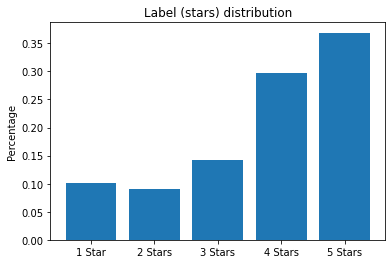

In [12]:
plot_bar_chart(
    labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
    values=np.array(stars_count, dtype=float) / sum(stars_count),
    title='Label (stars) distribution',
    ylabel='Percentage'
)

# Basic Feature Engineering

### BoW Feature

In [69]:
DICT_SIZE = 500
def create_feat_map(token_cnt_list: List[Tuple[str, int]], dict_size: int) -> Dict[str, int]:
    token_cnt_list.sort(key=lambda x:x[1], reverse=True)
    top_tokens = [x[0] for x in token_cnt_list[:dict_size]]
    feat_map, inv_feat_map = {}, {}

    for i, token in enumerate(top_tokens):
        feat_map[token] = i
        inv_feat_map[i] = token
    return feat_map, inv_feat_map

In [70]:
def extract_feature(feat_map: Dict[str, int], review_list: List[List[str]], normalize=True) -> np.ndarray:
    n_sample, n_feat = len(review_list), DICT_SIZE
    X = np.zeros((n_sample, n_feat))
    for i,tokens in enumerate(review_list):
        feat = X[i]
        for token in tokens:
            if token in feat_map:
                feat[feat_map[token]] +=1
#         if normalize and np.sum(X[i]) > 0:
#             X[i] /= np.sum(X[i])
    return X

In [71]:
feat_map, inv_feat_map = create_feat_map(token_cnt_list, DICT_SIZE)
X_train, y_train = extract_feature(feat_map, review_list), star_list

In [72]:
test_review_list, test_star_list = preprocess(file_dev, file_dev_label)
X_val, y_val = extract_feature(feat_map, test_review_list), test_star_list

# Model Design and Implementation

## Manul model

In [73]:
W = np.ones((5, DICT_SIZE)) / DICT_SIZE

def predict(W: np.ndarray, x: np.ndarray) -> np.ndarray:
    scores = np.dot(W,x)
    scores = np.exp(scores)
    scores = scores/np.sum(scores)
    return scores

fake_x = np.zeros(DICT_SIZE)
print(predict(W, fake_x))

[0.2 0.2 0.2 0.2 0.2]


In [74]:
def convert_indicator(y: int) -> np.ndarray:
    y_ind = np.zeros(5)
    y_ind[y-1] = 1.0
    return y_ind

print(convert_indicator(5))

[0. 0. 0. 0. 1.]


In [75]:
def get_gradient(W: np.ndarray, x: np.ndarray, y: int) -> np.ndarray:
    y = convert_indicator(y)
    scores = predict(W,x)
    diff = y - scores
    grad = np.dot(diff.reshape((-1,1)), x.reshape(1,-1))
    return -grad


def grad_update(W: np.ndarray, X_batch: List[np.ndarray], y_batch: List[int],
                lr: float = 0.01, regul: float = 0.1) -> np.ndarray:
    batch_grad = np.zeros_like(W)

    for feats, label in zip(X_batch,y_batch):
        grad = get_gradient(W, feats,label)
        batch_grad += grad
    batch_grad /= len(X_batch)
    W -= lr * batch_grad + regul * W
    return W


def compute_accuracy(W: np.ndarray, X: np.ndarray, y: List[int]) -> None:
    err = 0
    for feats, label in zip(X,y):
        prob = predict(W,feats)
        y_hat = prob.argmax() + 1
        if y_hat != label:
            err += 1
    print(f'Accuracy is {1.0 - err / len(X)}')


def compute_loss(W: np.ndarray, X: np.ndarray, y: List[int], regul: float) -> None:
    loss = 0
    for feats, label in zip(X,y):
        prob = predict(W,feats)
        max_idx = prob.argmax()
        loss += np.log(prob[max_idx])
    loss = -loss/len(X) + regul * np.sum(np.square(W))

    print(f'Loss is {loss}')

def train_RMLR(X_train: np.ndarray, y_train: List[int], batch_size: int,
               lr: float = 0.01, regul: float = 0.1) -> np.ndarray:
    print('Start training RMLR...')

    W = np.random.rand(5,DICT_SIZE)

    print('Initial performance')
    compute_loss(W, X_train, y_train, regul)
    compute_accuracy(W, X_val, y_val)

    n_batch = 0
    batch_X = []
    batch_y = []

    random_seq = [i for i in range(len(X_train))]

    while n_batch < 400:
        for idx in random_seq:
            batch_X.append(X_train[idx])
            batch_y.append(y_train[idx])
            if len(batch_X) == batch_size:
                W = grad_update(W, batch_X, batch_y, lr = lr ,regul=regul)
                n_batch += 1
                batch_X[:] = []
                batch_y[:] = []
                if n_batch % 100 == 0:
                    print('evaluate at batch:',n_batch)
                    compute_loss(W,X_train,y_train,regul)
                    compute_accuracy(W,X_val, y_val)
        np.random.shuffle(random_seq)
    print('Training completed')
    return W

In [76]:
W = train_RMLR(X_train,y_train,batch_size=100000, lr=1)

Start training RMLR...
Initial performance
Loss is 85.7503044578681
Accuracy is 0.2171645118145341
evaluate at batch: 100
Loss is 1.6094379718202156
Accuracy is 0.2171645118145341
evaluate at batch: 200
Loss is 1.6094379124581686
Accuracy is 0.2171645118145341
evaluate at batch: 300
Loss is 1.6094379124581686
Accuracy is 0.2168205846761353
evaluate at batch: 400
Loss is 1.6094379124581686
Accuracy is 0.10130564932169928
Training completed


In [45]:
y_pred_train = [predict(W, x).argmax()+1 for x in X_train]
y_pred_val = [predict(W, x).argmax()+1 for x in X_val]

In [46]:
def multiclass_accuracy_score(y_true: List[int], y_pred: List[int]) -> None:
    count = Counter()
    err = Counter()
    n_count, n_err = 0, 0
    for y,y_hat in zip(y_true,y_pred):
        count[y] += 1
        n_count += 1
        if y != y_hat:
            err[y] += 1
            n_err += 1

    print(f'Overall accuracy: {1 - n_err / n_count}')
    print(f'Per-class accuracy:')
    for star, cnt in sorted(count.items()):
        print(f'Star={star}, accuracy={1 - err[star] / cnt}')

In [47]:
# Evluation
multiclass_accuracy_score(y_train, y_pred_train)
multiclass_accuracy_score(y_val, y_pred_val)

Overall accuracy: 0.4958501712267386
Per-class accuracy:
Star=1, accuracy=0.42300723222793235
Star=2, accuracy=0.022017468257705675
Star=3, accuracy=0.08763572089891425
Star=4, accuracy=0.48899640934053423
Star=5, accuracy=0.7937760751829042
Overall accuracy: 0.4958501712267386
Per-class accuracy:
Star=1, accuracy=0.42300723222793235
Star=2, accuracy=0.022017468257705675
Star=3, accuracy=0.08763572089891425
Star=4, accuracy=0.48899640934053423
Star=5, accuracy=0.7937760751829042


In [48]:
def root_mean_square_err(y_true: List[int], y_pred: List[int]) -> None:
    s = 0.0
    for y,y_hat in zip(y_true,y_pred):
        s += np.square(y-y_hat)
    print(f'RMSE={np.sqrt(s / len(y_true))}')

In [49]:
root_mean_square_err(y_train, y_pred_train)
root_mean_square_err(y_val, y_pred_val)

RMSE=1.3149531150964102
RMSE=1.3149531150964102


## From pkg

### Linear model

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [107]:
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, solver='lbfgs', max_iter=30,
                           multi_class='auto', verbose=1, n_jobs=6)
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)

print(f'Trainig accuracy is {accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy is {accuracy_score(y_val, y_hat_val)}')

print(f'Trainig RMSE is {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Validation RMSE is {np.sqrt(mean_squared_error(y_val, y_hat_val))}')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:  2.4min finished


Trainig accuracy is 0.5549108497769153
Validation accuracy is 0.5525699000063691
Trainig RMSE is 1.096161664600941
Validation RMSE is 1.09793072734382


Training set


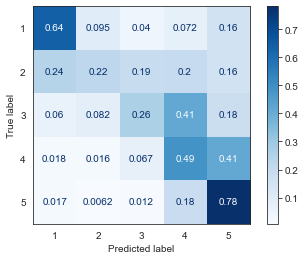

In [108]:
print('Training set')
disp = plot_confusion_matrix(model, X_train, y_train, cmap=plt.cm.Blues, normalize='true')

Validation set


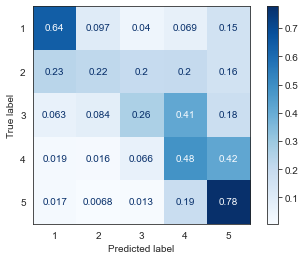

In [109]:
print('Validation set')
disp = plot_confusion_matrix(model, X_val, y_val, cmap=plt.cm.Blues, normalize='true')

### TF-iDF Feature

In [19]:
import pandas as pd
from textblob import Word
from textblob import TextBlob

from scipy.sparse import hstack
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [46]:
print(review_list[0])
print(star_list[0])
print(len(review_list))
print(len(star_list))

print(test_review_list[0])
print(test_star_list[0])
print(len(test_review_list))
print(len(test_star_list))
review_list = np.array([' '.join(line) for line in review_list])
test_review_list = np.array([' '.join(line) for line in test_review_list])

dr goldberg offers look general practitioner hes nice easy talk patronizing hes time seeing patients hes affiliated topnotch hospital nyu parents explained important case happens need surgery referrals specialists having really need sitting trying think complaints really drawing blank
5
1255353
1255353
notch doctor notch practice say surprised referred doctor think wonderful went best medical schools country really easy appointment minimal wait seen bedside manner great
5
157010
157010


MemoryError: Unable to allocate 43.4 GiB for an array with shape (1255353,) and data type <U9281

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=max_features,stop_words='english',lowercase=True)
# transformer = TfidfTransformer()
# features = transformer.fit_transform(review_list)
tfidf = TfidfVectorizer(
    max_features=10000
    )
X_train = tfidf.fit_transform(review_list)
y_train = np.array(star_list)

In [57]:
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10000,stop_words='english',lowercase=True)
transformer = TfidfTransformer()
x = transformer.fit_transform(vectorizer.fit_transform(review_list))

In [48]:
review_list[0]

'dr goldberg offers look general practitioner hes nice easy talk patronizing hes time seeing patients hes affiliated topnotch hospital nyu parents explained important case happens need surgery referrals specialists having really need sitting trying think complaints really drawing blank'

In [60]:
X_val = transformer.fit_transform(vectorizer.fit_transform(test_review_list))
# X_val = tfidf.fit_transform(test_review_list)
y_val = np.array(test_star_list)

### Linear

In [61]:
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, solver='lbfgs', max_iter=30,
                           multi_class='auto', verbose=1, n_jobs=6)
model.fit(X_train, y_train)
y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)

print(f'Trainig accuracy is {accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy is {accuracy_score(y_val, y_hat_val)}')

print(f'Trainig RMSE is {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Validation RMSE is {np.sqrt(mean_squared_error(y_val, y_hat_val))}')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:   24.1s finished


Trainig accuracy is 0.5822091475465466
Validation accuracy is 0.297700783389593
Trainig RMSE is 0.9572539300650779
Validation RMSE is 1.6232852774643016


### DecisionTreeClassifier

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt =  DecisionTreeClassifier(max_depth=10)
dt.fit(X_train,y_train)

y_hat_train = dt.predict(X_train)
y_hat_val = dt.predict(X_val)

print(f'Trainig accuracy is {accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy is {accuracy_score(y_val, y_hat_val)}')

print(f'Trainig RMSE is {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Validation RMSE is {np.sqrt(mean_squared_error(y_val, y_hat_val))}')

Trainig accuracy is 0.4523787333124627
Validation accuracy is 0.37098273995286923
Trainig RMSE is 1.4783110726452569
Validation RMSE is 1.815124099993138


### SVM

In [40]:
from sklearn.svm import SVC, LinearSVC
svc = LinearSVC(C=0.1)
svc.fit(X_train, y_train)

y_hat_train = svc.predict(X_train)
y_hat_val = svc.predict(X_val)

print(f'Trainig accuracy is {accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy is {accuracy_score(y_val, y_hat_val)}')

print(f'Trainig RMSE is {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Validation RMSE is {np.sqrt(mean_squared_error(y_val, y_hat_val))}')

Trainig accuracy is 0.6239272937572141
Validation accuracy is 0.39568817272785173
Trainig RMSE is 0.8662696968847627
Validation RMSE is 1.5879377816270317
